## Promoter region ResNet results

In [1]:
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import argparse
import itertools
import os.path

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    SAMPLE_IDS,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    PROJECT_PATH)

#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import Roadmap3D_tf
from epi_to_express.utils import pearsonR

2023-06-05 08:02:51.424849: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-05 08:02:51.424880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#load pred res epi_to_express
PRED_PATH = pathlib.Path("./model_results/predictions")
losses = pd.read_csv(f"{PRED_PATH}/blind_test.csv", sep='\t')

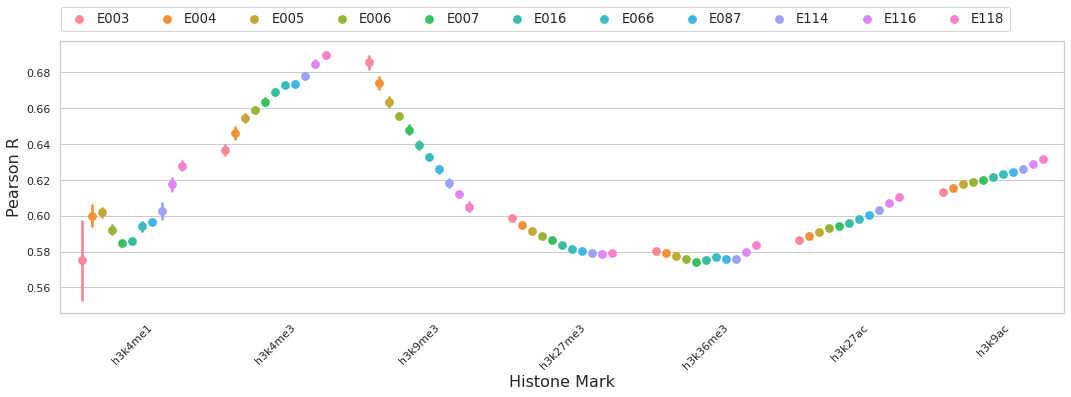

In [32]:
#plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "Pearson_R",
            x = "assay",  
            data = losses, ci="sd",join=False,
            dodge=0.7
                      )
# Put the legend out of the figure
perf_plt.legend(loc='upper left',bbox_to_anchor=(-0.006, 1.15),ncol=11,
                handletextpad=0.3,columnspacing=1.8)
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_cell.pdf"),dpi=1000,bbox_inches='tight')

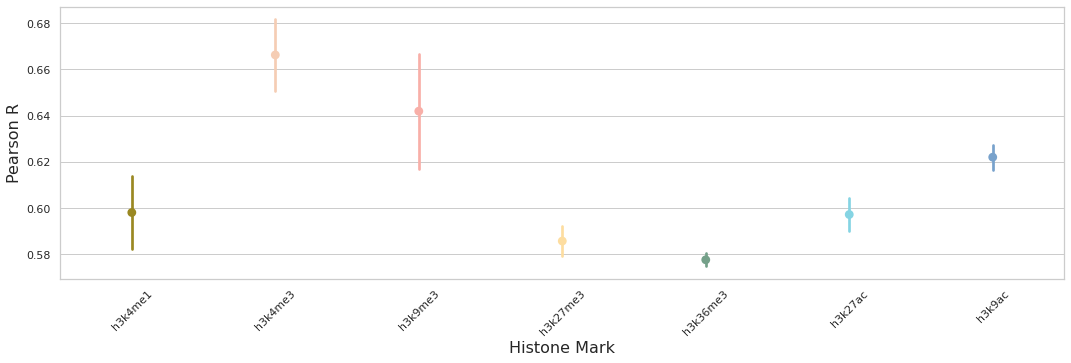

In [33]:
#plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(18, 5)})
#same wesanderson palette as used in R plots
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.3, palette=pal)
#perf_plt.set_title('MSE',fontsize=14)
perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
#perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_agg.pdf"),dpi=1000,bbox_inches='tight')

Top 3:

1. h3k4me3 - indicative of a promoter region [ref](https://science.sciencemag.org/content/366/6469/1134.fullref-11)
2. h3k9me3 - repressive mark - associated with heterochromatin - initially non-repressive, bookmarks promoters for compaction [ref](https://doi.org/10.1038/s41556-020-0536-6)
3. h3k9ac - associated with active promoters [ref](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-424)

The rest:
    
4. h3k4me1 - commonly associated with distal enhancers [ref](https://www.frontiersin.org/articles/10.3389/fcell.2020.00289/full)
5. h3k27ac - active enhancers and promoters(?) [ref](https://www.frontiersin.org/articles/10.3389/fgene.2020.00817/full)
6. h3k27me3 - repressive mark [ref](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009368)
7. h3k36me3 - heterochromatin [ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166828/)

Other papers tried to study this using SVMs and linear regression (they had a lot of limitations like only considering 1 or 2 cell types) but [one used linear regression](https://www.pnas.org/doi/10.1073/pnas.0909344107#:~:text=Histone%20Modification%20Levels%20Are%20Predictive%20of%20Gene%20Expression%20Across%20Different,within%20a%20given%20cell%20type.) did also find **H3K4me3** to be fairly predictive. 

Also [this paper](https://www.nature.com/articles/s41588-022-01026-x/figures/1) we had in journal club, which predicts histone marks from expression also had some of the highest scores in **H3K4me3** and **h3k9ac** (again less cells types and different data)

Also [Differential contribution to gene expression prediction of histone modifications at enhancers or promoters](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009368) Found **H3K27me3** — a histone modification associated with transcriptional gene repression — was the most prevalent mark in both enhancer and promoter model. Intewresting since H3K27me3 did so poorly here. **H3K4me3** was found to be the next highest mark in this study's promoter model when we consider overlapping marks between our data and theirs. Note theres was mouse ESC so could be differences caused by that too.




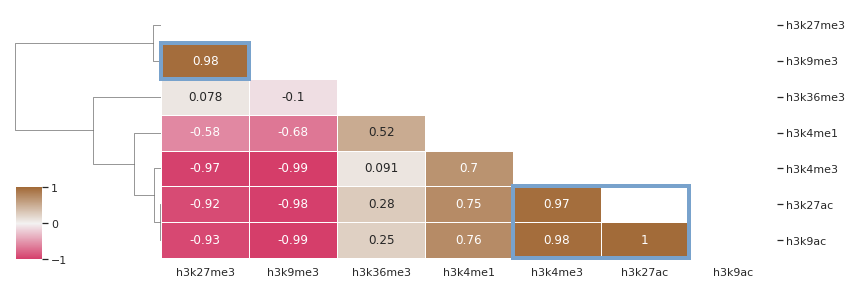

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
sns.set(rc={'figure.figsize':(12, 3)})
sns.set(font_scale = 1.2)
sns.set_theme(style="white")


losses_agg = losses.copy()
losses_agg['avg_Pearson_R'] = losses_agg.groupby(['assay', 'cell','fold'])['Pearson_R'].transform('mean')
losses_agg = losses_agg.drop_duplicates(subset=['assay', 'cell','fold'])
losses_agg.drop(['Pearson_R'], axis=1,inplace=True)
losses_agg_pov = losses_agg.pivot(index=['cell','fold'],columns='assay', values='avg_Pearson_R').reset_index(drop=True)
losses_agg_pov = losses_agg_pov.rename_axis(None, axis=1)  
losses_agg_pov = losses_agg_pov.rename_axis(None, axis=0)
corr = losses_agg_pov.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(1080, 400, as_cmap=True)
# plot with hierach
g = sns.clustermap(corr,
                   cmap=cmap, vmax=1,vmin=-1, 
                   linewidths=.5, cbar_kws={"shrink": .5},
                   annot=True,figsize=(12,5)
                  )

mask = np.triu(np.ones_like(corr))
values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_col_dendrogram.set_visible(False)

#some numbers still appear, hide them
#from matplotlib.patches import Rectangle
ax = g.ax_heatmap
ax.text(2,0.5,"AAAAAAAAAAAAAA"*3,backgroundcolor='w',color='w')
ax.text(2,1.5,"AAAAAAAAAAAAAA"*3,backgroundcolor='w',color='w')
ax.text(3,2.5,"AAAAAAAAAAAAAAAAAAA"*2,backgroundcolor='w',color='w')
ax.text(5,3.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.text(5,4.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.add_patch(Rectangle((4, 5), 2, 2, fill=False, edgecolor=pal[6], lw=4, clip_on=False))
ax.add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor=pal[6], lw=4, clip_on=False))
g.ax_cbar.set_position((0.025, .087, .03, .2))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_corr_mat.pdf"),dpi=1000,bbox_inches='tight')
plt.show()

This correlation plot shows how the performance across folds and cells correlates across the model trained on different histone marks. We can notice trends heres so if an model does well in cell type A with histone mark 1 we can check what other histone marks also showed good performance in the same cell type (positive correlation) or conversley didn't do so well (negative).

Results:
  * h3k27ac, h3k4me3 and h3k9ac show near perfect positive correlation - all active promoters ([ref h3k4me3](https://pubmed.ncbi.nlm.nih.gov/28004446/)). This makes sense that h3k27ac as the model would only pick up on it's promoter signal (even though it also indicates enhancers) since the window size is 6k bp around the TSS.
  * h3k27me3 and h3k9me3 show near perfect positive correlation - both repressive marks.
  * These two groups show a near perfect negative correlation with one another. This means that for the cells that active promoter marks are strongly predictive, repressive marks won't be and vice-versa. This is interesting since it could indicate that in certain cell types/states different marks are more indicitive of expression.
  * h3k36me3 (heterochromatin) is highly correlated with h3k4me1 (distal enhancers) but don't seem to be correlated with others (next highest for h3k4me1 is h3k27ac which makes sense)
  
So we should look to see if there is anydistinguishing feature across cell types driving when certain histone mark types predict better  

### Hypothesis: Performance increasing, the more differentiated the cell?

Numbers from ROADMAP match performance, where does ordering from ROADMAP come from?

Rank of perf on ESC derived surronded by perf on ESC undiff

ESDR.H1.BMP4.MESO - first step of diff 
ESDR.H1.BMP4.TROP - 4 days after fert (very early), first cells to diff, derives from ESC
ESC.H1 - 4/5 days after fert 
ESDR.H1.MSC	- Mesenchymal Stem Cells
ESC.HUES64 - Human embryonic stem cell line derived from human blastocysts
ESDR.H1.NEUR.PROG - Neural progenitors (more specialised)

All derived ESC from E003

In [113]:
rm_meta[["Epigenome ID (EID)","GROUP","Epigenome Mnemonic","ANATOMY","TYPE"]]

,Epigenome ID (EID),GROUP,Epigenome Mnemonic,ANATOMY,TYPE
10,E118,ENCODE2012,LIV.HEPG2.CNCR,LIVER,CellLine
9,E116,ENCODE2012,BLD.GM12878,BLOOD,PrimaryCulture
8,E114,ENCODE2012,LNG.A549.ETOH002.CNCR,LUNG,CellLine
6,E087,Other,PANC.ISLT,PANCREAS,PrimaryTissue
7,E066,Other,LIV.ADLT,LIVER,PrimaryTissue
0,E016,ESC,ESC.HUES64,ESC,PrimaryCulture
2,E007,ES-deriv,ESDR.H1.NEUR.PROG,ESC_DERIVED,ESCDerived
5,E006,ES-deriv,ESDR.H1.MSC,ESC_DERIVED,ESCDerived
4,E005,ES-deriv,ESDR.H1.BMP4.TROP,ESC_DERIVED,ESCDerived
3,E004,ES-deriv,ESDR.H1.BMP4.MESO,ESC_DERIVED,ESCDerived


So the rank of performance on the different cells is the same across the two groups and the exact opposite across teh active promoter and repressive mark groups so there must be some attribute of the cells that are driving this.

Okay so the cell types that have better performance in the active promoter group of histone marks, are all from primary tissues whereas the repressive marks had better performance in the differentiated Embryonic stem cells (ESCs). So is this a good mark of age of the cell? Perhaps repressive marks fair better before cells fully differentiate whereas active do better after.

Let's plot just to make sure

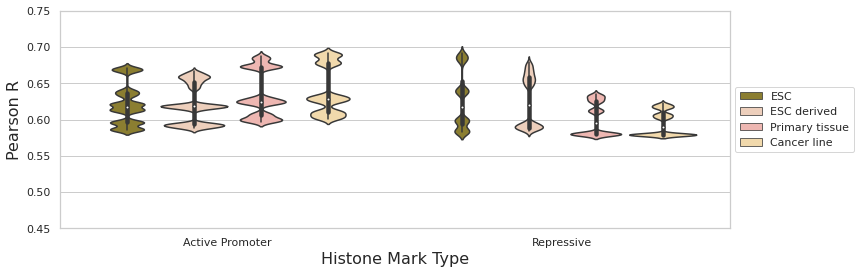

In [80]:
#split 4 groups
#first get perf rank for each hist mark so can prove, hist marks in the two groups discussed above is the same
#and the opposite to one another i.e. backing up the corr results
#get average of folds
losses_agg_ca = losses_agg.copy()
losses_agg_ca['avg_Pearson_R'] = losses_agg_ca.groupby(['assay', 'cell'])['avg_Pearson_R'].transform('mean')
losses_agg_ca = losses_agg_ca.drop_duplicates(subset=['assay', 'cell'])
losses_agg_ca.sort_values(['assay','avg_Pearson_R'],
                       ascending=[True, False],inplace=True)

#check rank prom group
act_prom_rank = losses_agg_ca[losses_agg_ca['assay']=='h3k27ac']['cell'].to_list()
#check rank repress group
#last position is diff.......
repres_rank = losses_agg_ca[losses_agg_ca['assay']=='h3k9me3']['cell'].to_list()

rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))
rm_meta['Epigenome ID (EID)'] = pd.Categorical(rm_meta['Epigenome ID (EID)'], act_prom_rank)
rm_meta.sort_values('Epigenome ID (EID)',inplace=True)

losses_ = losses.copy()
#add histone mark groups
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27ac','h3k4me3','h3k9ac']), 
                                     'Active Promoter', 'Other')
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27me3','h3k9me3']), 
                                     'Repressive', losses_['hist_mark_group'])

#just include repressive and active promoter marks
losses_ = losses_[losses_['hist_mark_group'].isin(['Active Promoter','Repressive'])]

#add cell anatomy type
losses_ = pd.merge(losses_, rm_meta[["Epigenome ID (EID)", "ANATOMY"]], left_on='cell',
                   right_on="Epigenome ID (EID)", how="left")
losses_['cell_anatomy_grp'] = np.where(losses_['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                       'ESC derived','Primary tissue')

#add cell anatomy type 2
losses_['cell_anatomy_grp2'] = np.where(losses_['ANATOMY'].isin(['ESC']),
                                       'ESC',np.where(losses_['ANATOMY'].isin(['ESC_DERIVED']),'ESC derived',
                                                      np.where(losses_['cell'].isin(['E118','E114']),
                                                               'Cancer line','Primary tissue')))

#Mann-Whitney U-Test
import scipy.stats as stats
import statsmodels.stats.multitest as multi
# perform two-sided test.
grps = set(losses_['hist_mark_group'])
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 4)})
sns.set(font_scale = 1.2)
sns.set_theme(style="whitegrid")
# Plot
ax = sns.violinplot(x="hist_mark_group", y="Pearson_R", hue="cell_anatomy_grp2",
                    palette=pal,data=losses_)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Histone Mark Type',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)
ax.set(ylim=(0.45, 0.75))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_cell_state_perf.pdf"),dpi=1000,bbox_inches='tight')
plt.show()

This shows promoter model does a better job in Primary tissue and cancer lines with active marks used in the model but a better job in ESC and ESC derived cells with repressive marks. **Key point**, this split doesn't happen with chormoformer!!

Including the two marks h3k36me3 (heterochromatin) and h3k4me1 (distal enhancers) which are correlated with eachother but don't form either the **active promoter** (h3k27ac, h3k4me3, h3k9ac) or **repressive groups** (h3k27me3, h3k9me3) skews the standard deviation of the correlation scores, making them appear much higher.

We can exclude them and see a lot smaller a range of standard deviations for the genes:

**Note**:
* Active promoter group of marks has less variance in genes' Pearson R than repressive group of marks
* Overall, it appears genes' scores are **fairly consistent regardless of cell or mark, i.e. low sd for all** (excluding outliers in Other group). 

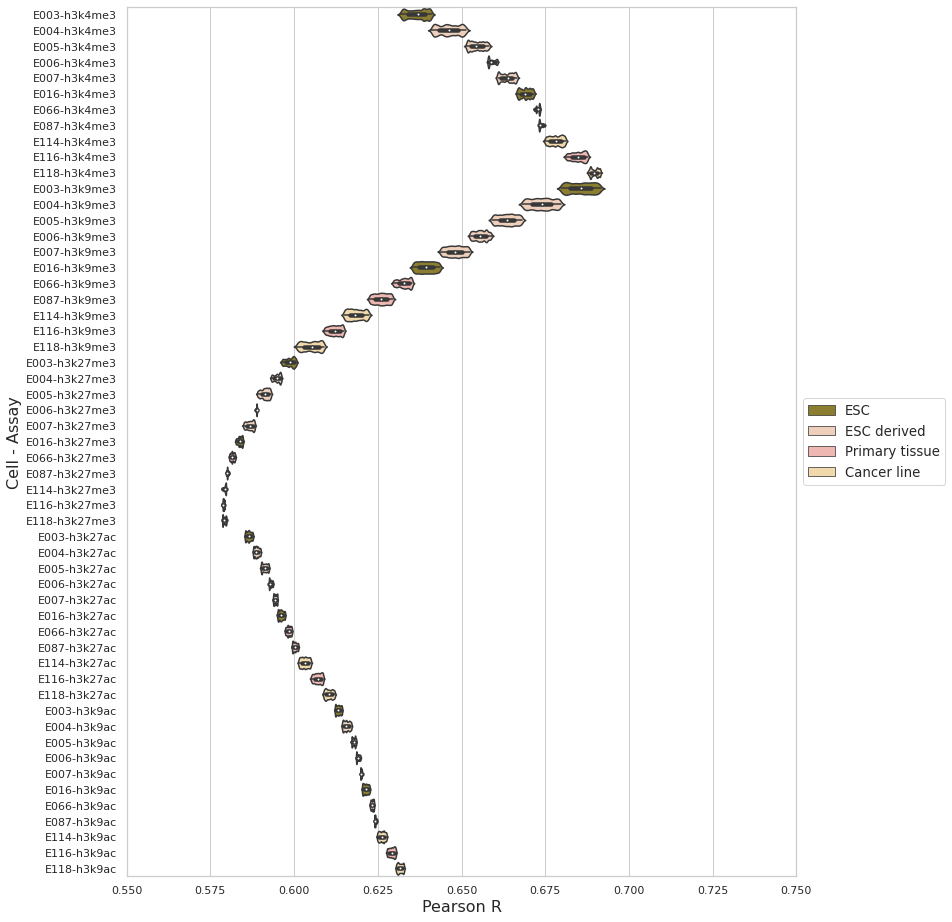

In [93]:
#split by cell + fold
losses_ = losses.copy()
#add histone mark groups
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27ac','h3k4me3','h3k9ac']), 
                                     'Active Promoter', 'Other')
losses_['hist_mark_group'] = np.where(losses_['assay'].isin(['h3k27me3','h3k9me3']), 
                                     'Repressive', losses_['hist_mark_group'])

#just include repressive and active promoter marks
losses_ = losses_[losses_['hist_mark_group'].isin(['Active Promoter','Repressive'])]

#add cell anatomy type
losses_ = pd.merge(losses_, rm_meta[["Epigenome ID (EID)", "ANATOMY"]], left_on='cell',
                   right_on="Epigenome ID (EID)", how="left")
losses_['cell_anatomy_grp'] = np.where(losses_['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                       'ESC derived','Primary tissue')

#add cell anatomy type 2
losses_['cell_anatomy_grp2'] = np.where(losses_['ANATOMY'].isin(['ESC']),
                                       'ESC',np.where(losses_['ANATOMY'].isin(['ESC_DERIVED']),'ESC derived',
                                                      np.where(losses_['cell'].isin(['E118','E114']),
                                                               'Cancer line','Primary tissue')))
#get cells + mark
losses_['cell_assay'] = losses_[['cell', 'assay']].agg('-'.join, axis=1)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 16)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(y="cell_assay", x="Pearson_R",hue="cell_anatomy_grp2",
                    palette=pal,data=losses_,dodge=False)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_ylabel('Cell - Assay',fontsize=16)
ax.set_xlabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=11)
ax.set(xlim=(0.55, 0.75))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_cell_state_split_cell_hist.pdf"),dpi=1000,bbox_inches='tight')

plt.show()

### why bimodal? 

Still see even when split cells into two/four groups or even separated by cell or K fold. So it appears this is driven by the genes themselves. It appears certain groups of genes will perform better than others.

Bimodial because of combination of hist mark and cell type (above)

In [94]:
#load hist_mark activity data
agg_hist_exp = pd.read_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp.csv'),sep='\t')
agg_hist_exp_sub = pd.read_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp_4_grps.csv'),
                               sep='\t')

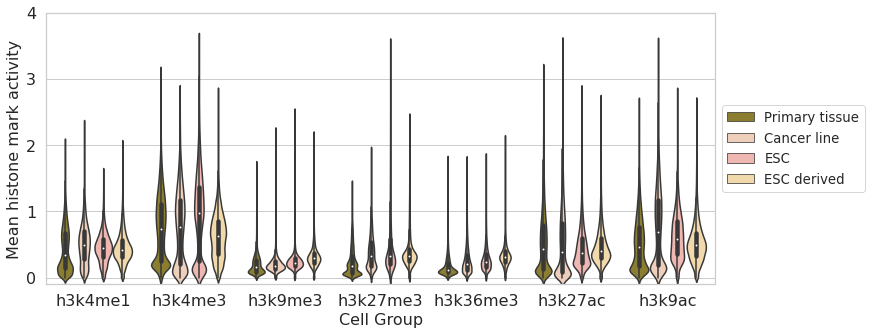

In [95]:
#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


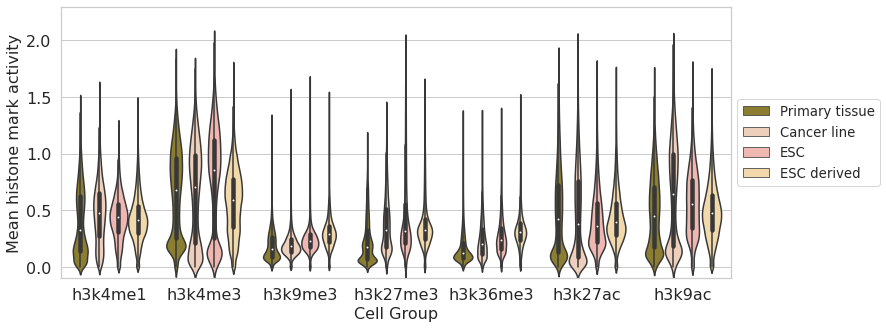

In [96]:
#try with arc sinh transformed hist mark signal to try and rule out seq depth

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])
#arc sinh transform data
agg_hist_exp_sub_hist['value'] = np.arcsinh(agg_hist_exp_sub_hist['value'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 2.3))

plt.show()


Expression levels are **higher in ESC derived cells** compared to primary tissue but I don't think we should compare expression like this.

One of the two repressive marks (h3k9me3) shows **greater activity in the TSS of ESC cells**. However, so too does **two of the three active marks** (h3k27ac, h3k9ac). This remains the same after arc-sinh transforming the marks so likely not to be a sequencing depth effect.

So expression levels are **higher** in ESC and so too is **histone mark activity levels** but **not proportions of expressed genes**. Note that the higher levels of histone mark activities probably isn't driven by seq depth as arc-sin transforming them gave the same result.

Let's look at histone mark activity across active and inactive genes - using active/inactive definition from the chromoformer paper (based on median gene exp from all cells) - 

whether an expression level of a gene is above the median for the cell or not. This problem formulation was first proposed by [Singh et al.](https://pubmed.ncbi.nlm.nih.gov/27587684/), and it has been so far widely adopted for many studies, including the three aforementioned baseline studies. 

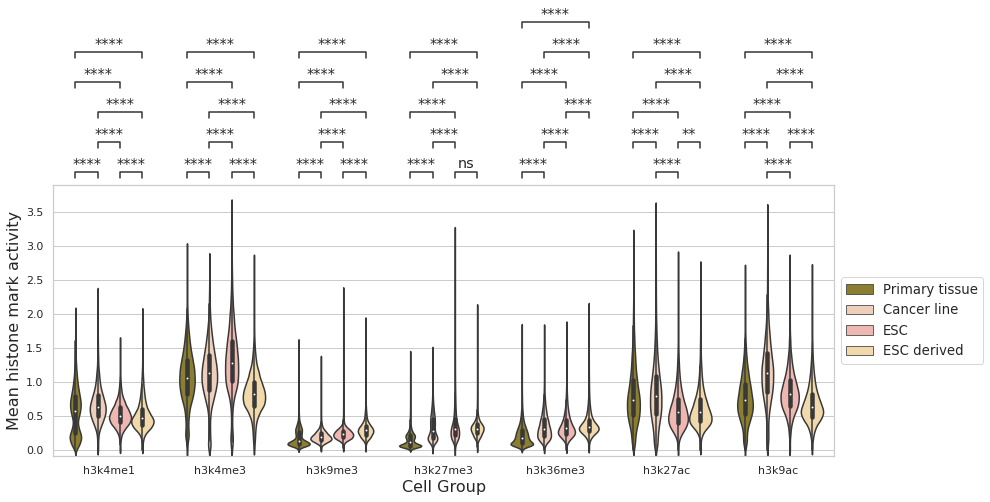

In [106]:
#how variable is the hist mark across genes that are active/inactive
#good to understand - might point to why repressive marks beat active

#look at histone mark activity in active genes

#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(14, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
#filt to just active
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist[agg_hist_exp_sub_hist['label']==1]
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)
add_stat_annotation(ax, data=agg_hist_exp_sub_hist, x="variable", y="value", hue="cell_group",
                    #order=order,
                    box_pairs=[(("h3k4me1", "Primary tissue"), ("h3k4me1", "Cancer line")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "ESC"), ("h3k4me1", "ESC derived")),
                               
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "Cancer line")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "ESC"), ("h3k4me3", "ESC derived")),
                               
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "Cancer line")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "ESC"), ("h3k9me3", "ESC derived")),
                            
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "Cancer line")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "ESC"), ("h3k27me3", "ESC derived")),
                               
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "Cancer line")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "ESC"), ("h3k36me3", "ESC derived")),
                               
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "Cancer line")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "ESC"), ("h3k27ac", "ESC derived")),
                               
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "Cancer line")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "ESC"), ("h3k9ac", "ESC derived")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='outside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=11)
ax.set(ylim=(-0.1, 3.9))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_hist_act_act_gene.pdf"),dpi=1000,bbox_inches='tight')
plt.show()


When we consider only the genes that are highly expressed: 
* Primary tissue cells have greater histone mark activity in **all the active promoter marks** h3k27ac, h3k4me3 and h3k9ac.
* ESC derived cells have greater histone mark activity in **all the repressive marks** h3k27me3 and h3k9me3

This association was not present when considering all genes. It is likely that this increased activity will have lead to the increased performance in the model on the consecutive marks and cell types.

When we look at the 4 groups Cancert line, Primary tissue, ESC and ESC derived we notice:

**Repressive marks**
* ESC and ESC derived cells have higher histone mark activity in the repressive marks h3k27me3 and h3k9me3 than Primary tissue and Cancer lines. 
* ESC derived cells have significantly higher activity than ESC cells in h3k9me3 but not h3k27me3. 
* Primary tissue also has significantly lower acitivty in the two repressive marks than Cancer lines.
* Order of incressing activity - Primary tissue < Cancer line < ESC < ESC derived

**Active Promoter marks**
* Primary tissue and Cancer lines have greater activity in some of the active promoter marks (h3k27ac for both) and (h3k9ac for cancer lines) but not h3k4me3 when compared to ESC but for all when compared to ESC derived h3k27ac, h3k4me3 and h3k9ac.
* Overall, in these marks, there appears to be more activity in Cancer lines than primary tissue - maybe to do with epithelial-to-mesenchymal transition (EMT) occurring in the cancer lines? Or jsut their hetrogeneity?
* Also, overall, in these marks, there is more activity in ESC than ESC derived cells.

This all reconfirms what the results of the ML performances showed.

What if we look at genes which aren't expressed:

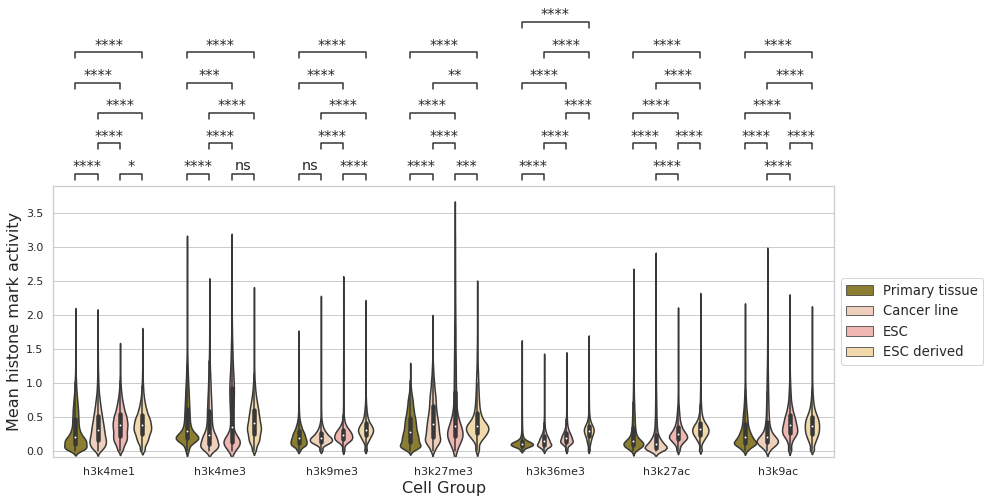

In [107]:
#how variable is the hist mark across genes that are active/inactive
#good to understand - might point to why repressive marks beat active

#look at histone mark activity in inactive genes

#plot expression across the two cell groups
import seaborn as sns
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(14, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

agg_hist_exp_sub_hist = agg_hist_exp_sub.copy()
#filt to just inactive
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist[agg_hist_exp_sub_hist['label']==0]
agg_hist_exp_sub_hist.drop(['log2RPKM'], axis=1,inplace=True)
agg_hist_exp_sub_hist.drop(['label'], axis=1,inplace=True)
agg_hist_exp_sub_hist = agg_hist_exp_sub_hist.melt(id_vars=['cell_group'])

# Plot
ax = sns.violinplot(x="variable", y="value", hue="cell_group",
                    palette=pal,data=agg_hist_exp_sub_hist)
add_stat_annotation(ax, data=agg_hist_exp_sub_hist, x="variable", y="value", hue="cell_group",
                    #order=order,
                    box_pairs=[(("h3k4me1", "Primary tissue"), ("h3k4me1", "Cancer line")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "ESC"), ("h3k4me1", "ESC derived")),
                               
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "Cancer line")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "ESC"), ("h3k4me3", "ESC derived")),
                               
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "Cancer line")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "ESC"), ("h3k9me3", "ESC derived")),
                            
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "Cancer line")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "ESC"), ("h3k27me3", "ESC derived")),
                               
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "Cancer line")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "ESC"), ("h3k36me3", "ESC derived")),
                               
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "Cancer line")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "ESC"), ("h3k27ac", "ESC derived")),
                               
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "Cancer line")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "ESC"), ("h3k9ac", "ESC derived")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='outside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=11)
ax.set(ylim=(-0.1, 3.9))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"prom_model_hist_act_inact_gene.pdf"),dpi=1000,bbox_inches='tight')
plt.show()


When we consider only the genes that are not expressed, ESC derived cells had higher histone mark activity across all marks

This holds when split into 4 groups, ESC and ESC derived have highert activity than primary tissue and cancer lines. 


We want stems cells to be able to express diff genes to differentiate so you will see more open chrom
Maybe the more hist mark actiivty makes sense under this idea
We know chromatin more open in ESC before diff

Other mechanism on top of hist mod contributes to reg in less differentiated cells, why perf worse in less diff cells

In literature:

* you have genome-wide broad H3K27ac domains before zygotic genome activation and then changes extensively, [Dynamics of histone acetylation during human early embryogenesis](https://www.nature.com/articles/s41421-022-00514-y)
* Gives the same opinion that more H3K27ac in less diferentiated cells (early embryo cells)

* prom seq model shows the need to consider multiple marks and cell types as perf depends on choice 
* talk about mark groups and cell groups
* also top mark(s) should be highlighted

## Chromoformer results

In [114]:
#load chromoformer res
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import argparse
import itertools
import os.path

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    SAMPLE_IDS,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    PROJECT_PATH)

import pandas as pd
import pathlib
from epi_to_express.constants import(
    ASSAYS,
    SAMPLES,
    SAMPLE_IDS)

PRED_PATH = pathlib.Path("./model_results/predictions")

losses_chrom = pd.read_csv(f"{PRED_PATH}/chromoformer_blind_test.csv", sep='\t')
#also loadf perf using all hist marks
losses_chrom_all = pd.read_csv(f"{PRED_PATH}/chromoformer_all_hist_perf.csv")

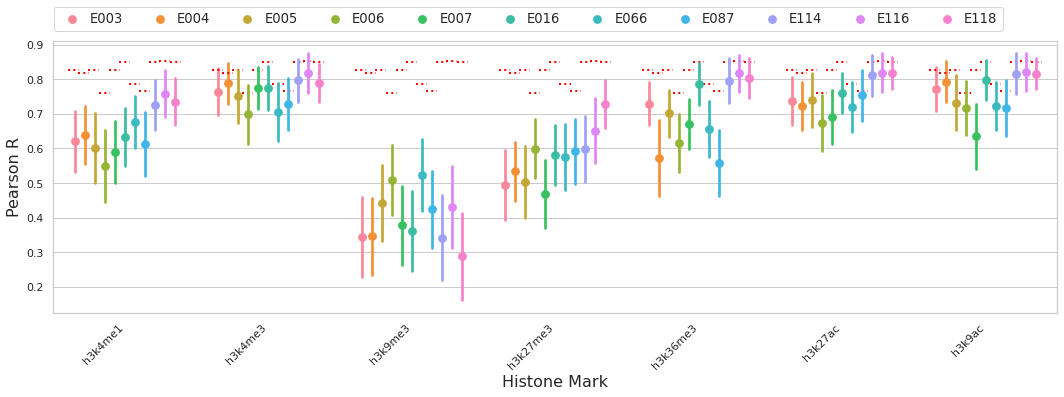

In [119]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom, ci="sd",join=False,
            dodge=0.7
                      )
#add perf of chromoformer for each cell type
cell_mean_perf = losses_chrom_all.groupby(['cell'])['Pearson_R'].mean().values
for ind,asy_i in enumerate(ASSAYS):
    for c_ind,cell_i in enumerate(SAMPLE_IDS):
        perf_plt.axhline(y=cell_mean_perf[c_ind], 
                         lw=2, c='red', ls=':', 
                         xmin=(ind/len(ASSAYS))+.015+((c_ind)/len(SAMPLE_IDS))/9, 
                         xmax=(ind/len(ASSAYS))+.026+((c_ind)/len(SAMPLE_IDS))/9)
    
# Put the legend out of the figure
#perf_plt.tick_params(axis='x', rotation=45)
perf_plt.set_xticklabels(perf_plt.get_xticklabels(), rotation=45, horizontalalignment='right')
# Put the legend out of the figure
perf_plt.legend(loc='upper left',bbox_to_anchor=(-0.006, 1.15),ncol=11,
                handletextpad=0.3,columnspacing=1.8)

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_model_cell_mark.pdf"),dpi=1000,bbox_inches='tight')

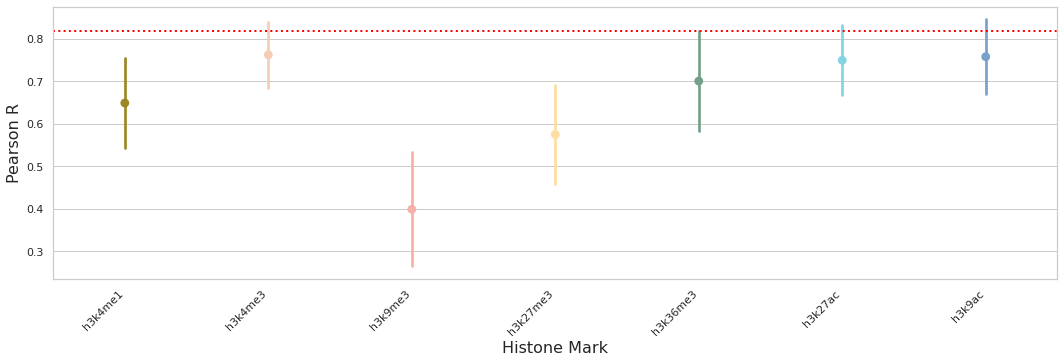

In [121]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 5)})
#same wesanderson palette as used in R plots
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom, ci="sd",join=False,
            dodge=0.3, palette=pal)
#add in mean perf of chromoformer using all hist marks
mean_perf = losses_chrom_all['Pearson_R'].mean()
perf_plt.axhline(y=mean_perf, 
                 lw=2, c='red', ls=':', 
                 xmin=0,xmax=1)
# Put the legend out of the figure
perf_plt.legend([],[], frameon=False)
#perf_plt.tick_params(axis='x', rotation=45)
perf_plt.set_xticklabels(perf_plt.get_xticklabels(), rotation=45, horizontalalignment='right')

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_model_cell.pdf"),dpi=1000,bbox_inches='tight')

Top 3:

1. h3k4me3 - indicative of a promoter region [ref](https://science.sciencemag.org/content/366/6469/1134.fullref-11)
2. h3k9ac - associated with active promoters [ref](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-424)
3. h3k27ac - active enhancers and promoters [ref](https://www.frontiersin.org/articles/10.3389/fgene.2020.00817/full)

The rest:

4. h3k36me3 - heterochromatin [ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166828/)    
5. h3k4me1 - commonly associated with distal enhancers [ref](https://www.frontiersin.org/articles/10.3389/fcell.2020.00289/full)
6. h3k27me3 - repressive mark [ref](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009368)
7. h3k9me3 - repressive mark - associated with heterochromatin - initially non-repressive, bookmarks promoters for compaction [ref](https://doi.org/10.1038/s41556-020-0536-6)

* Compared to the other model, the biggest changes in rank are for  h3k9me3 which dropped from 3 best to 7 best predictive mark and h3k27ac which increased from 5 to 3 best (there is very little performance difference in the first 3). h3k9me3 actually dropped in perf compared to the prom model (substantially mean Pearson R from 0.64 to 0.4).
* Performance of incorporating all marks in the chromoformer model only marginally increases Perason R scores but does consistently increase it. I think it would be worth testing training chromoformer on combinations of marks. I was thinking of combining h3k4me3 and h3k9ac with active enhancer/hetrochromatin marks (h3k27ac, h3k36me3, h3k4me1, h3k27me3, h3k9me3). The idea would be to test if we can obtain the same performance with just 2 marks as using all. This also avoids testing all combinations which would take a long time.

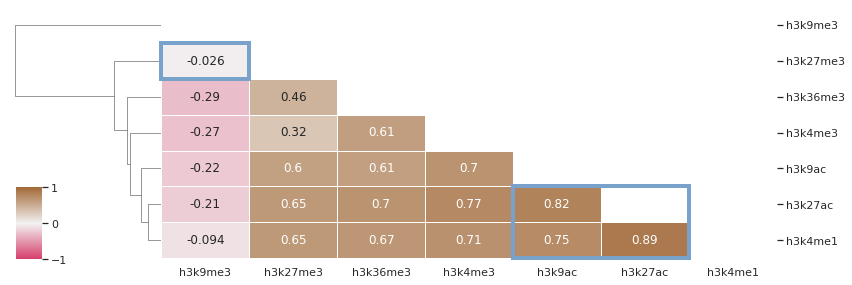

In [125]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white")

losses_chrom_agg = losses_chrom.copy()
losses_chrom_agg['avg_Pearson_R'] = losses_chrom_agg.groupby(['assay', 'cell','fold'])['Pearson_R'].transform('mean')
losses_chrom_agg = losses_chrom_agg.drop_duplicates(subset=['assay', 'cell','fold'])
losses_chrom_agg.drop(['Pearson_R'], axis=1,inplace=True)
losses_chrom_agg_pov = losses_chrom_agg.pivot(index=['cell','fold'],columns='assay', values='avg_Pearson_R').reset_index(drop=True)
losses_chrom_agg_pov = losses_chrom_agg_pov.rename_axis(None, axis=1)  
losses_chrom_agg_pov = losses_chrom_agg_pov.rename_axis(None, axis=0)
corr_chrom = losses_chrom_agg_pov.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(1080, 400, as_cmap=True)
# plot with hierach
g = sns.clustermap(corr_chrom,
                   cmap=cmap, vmax=1,vmin=-1, 
                   linewidths=.5, cbar_kws={"shrink": .5},
                   annot=True,figsize=(12,5)
                  )

mask = np.triu(np.ones_like(corr_chrom))
values = g.ax_heatmap.collections[0].get_array().reshape(corr_chrom.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_col_dendrogram.set_visible(False)

#some numbers still appear, hide them
#from matplotlib.patches import Rectangle
ax = g.ax_heatmap
ax.text(1,0.5,"AAAAAAAAAAAAAAAAAAAA"*3,backgroundcolor='w',color='w')
ax.text(2,1.5,"AAAAAAAAAAAAA"*3,backgroundcolor='w',color='w')
ax.text(3,2.5,"AAAAAAAAAAAAAAA"*2,backgroundcolor='w',color='w')
ax.text(5,3.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.text(5,4.5,"AAAAAAAAAAAAAAA",backgroundcolor='w',color='w')
ax.add_patch(Rectangle((4, 5), 2, 2, fill=False, edgecolor=pal[6], lw=4, clip_on=False))
ax.add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor=pal[6], lw=4, clip_on=False))
g.ax_cbar.set_position((0.025, .087, .03, .2))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_model_corr_mat.pdf"),dpi=1000,bbox_inches='tight')
plt.show()

Corr structure found in promoter model isn't here for chromoformer (distal model)

high correlation between the top performing marks (h3k27ac, h3k9ac, h3k4me1)

Weak neg correlation with worst performing and rest (h3k9me3)

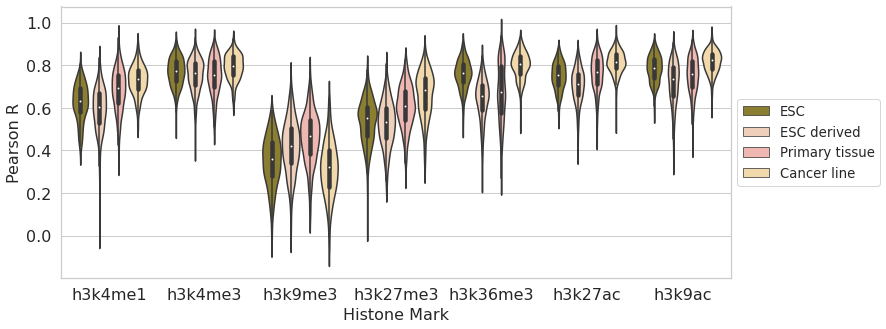

In [167]:
#Check perf across 4 cell groups
#Split this by active and repressive marks for promoter model but no need here since that split 
#in the correlations (above) isn't present like with the promoter model
#load roadmap metadata
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))

losses_chrom_ = losses_chrom.copy()

#add cell anatomy type
losses_chrom_ = pd.merge(losses_chrom_, rm_meta[["Epigenome ID (EID)", "ANATOMY"]], left_on='cell',
                         right_on="Epigenome ID (EID)", how="left")
losses_chrom_['cell_anatomy_grp'] = np.where(losses_chrom_['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                             'ESC derived','Primary tissue')

#add cell anatomy type 2
losses_chrom_['cell_anatomy_grp2'] = np.where(losses_chrom_['ANATOMY'].isin(['ESC']),
                                              'ESC',np.where(losses_chrom_['ANATOMY'].isin(['ESC_DERIVED']),
                                                             'ESC derived',
                                                             np.where(losses_chrom_['cell'].isin(['E118','E114']),
                                                                      'Cancer line','Primary tissue')))
    
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(x="assay", y="Pearson_R", hue="cell_anatomy_grp2",
                    palette=pal,data=losses_chrom_)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Histone Mark',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=16)

plt.show()

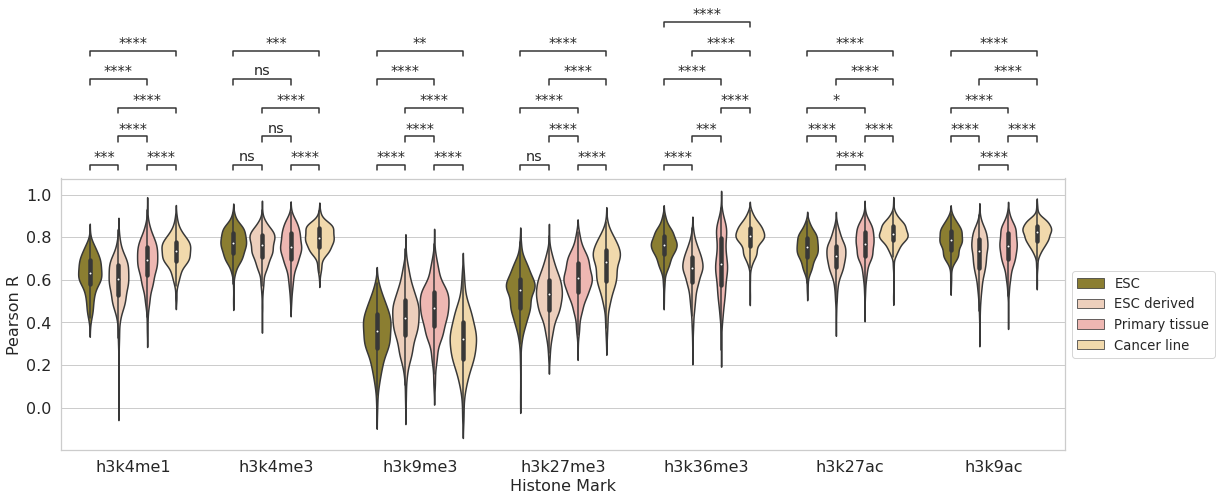

In [168]:
#Check perf across 4 cell groups
#Split this by active and repressive marks for promoter model but no need here since that split 
#in the correlations (above) isn't present like with the promoter model
#load roadmap metadata
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))

losses_chrom_ = losses_chrom.copy()

#add cell anatomy type
losses_chrom_ = pd.merge(losses_chrom_, rm_meta[["Epigenome ID (EID)", "ANATOMY"]], left_on='cell',
                         right_on="Epigenome ID (EID)", how="left")
losses_chrom_['cell_anatomy_grp'] = np.where(losses_chrom_['ANATOMY'].isin(['ESC', 'ESC_DERIVED']),
                                             'ESC derived','Primary tissue')

#add cell anatomy type 2
losses_chrom_['cell_anatomy_grp2'] = np.where(losses_chrom_['ANATOMY'].isin(['ESC']),
                                              'ESC',np.where(losses_chrom_['ANATOMY'].isin(['ESC_DERIVED']),
                                                             'ESC derived',
                                                             np.where(losses_chrom_['cell'].isin(['E118','E114']),
                                                                      'Cancer line','Primary tissue')))
    
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(18, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
# Plot
ax = sns.violinplot(x="assay", y="Pearson_R", hue="cell_anatomy_grp2",
                    palette=pal,data=losses_chrom_)
add_stat_annotation(ax, data=losses_chrom_, x="assay", y="Pearson_R",hue="cell_anatomy_grp2",
                    box_pairs=[(("h3k4me1","ESC"), ("h3k4me1","ESC derived")),
                               (("h3k4me1","ESC"), ("h3k4me1","Primary tissue")),
                               (("h3k4me1","ESC"), ("h3k4me1","Cancer line")),
                               (("h3k4me1","ESC derived"), ("h3k4me1","Primary tissue")),
                               (("h3k4me1","ESC derived"), ("h3k4me1","Cancer line")),
                               (("h3k4me1","Primary tissue"), ("h3k4me1","Cancer line")),
                               
                               (("h3k4me3","ESC"), ("h3k4me3","ESC derived")),
                               (("h3k4me3","ESC"), ("h3k4me3","Primary tissue")),
                               (("h3k4me3","ESC"), ("h3k4me3","Cancer line")),
                               (("h3k4me3","ESC derived"), ("h3k4me3","Primary tissue")),
                               (("h3k4me3","ESC derived"), ("h3k4me3","Cancer line")),
                               (("h3k4me3","Primary tissue"), ("h3k4me3","Cancer line")),
                               
                               (("h3k9me3","ESC"), ("h3k9me3","ESC derived")),
                               (("h3k9me3","ESC"), ("h3k9me3","Primary tissue")),
                               (("h3k9me3","ESC"), ("h3k9me3","Cancer line")),
                               (("h3k9me3","ESC derived"), ("h3k9me3","Primary tissue")),
                               (("h3k9me3","ESC derived"), ("h3k9me3","Cancer line")),
                               (("h3k9me3","Primary tissue"), ("h3k9me3","Cancer line")),
                               
                               (("h3k27me3","ESC"), ("h3k27me3","ESC derived")),
                               (("h3k27me3","ESC"), ("h3k27me3","Primary tissue")),
                               (("h3k27me3","ESC"), ("h3k27me3","Cancer line")),
                               (("h3k27me3","ESC derived"), ("h3k27me3","Primary tissue")),
                               (("h3k27me3","ESC derived"), ("h3k27me3","Cancer line")),
                               (("h3k27me3","Primary tissue"), ("h3k27me3","Cancer line")),
                               
                               (("h3k36me3","ESC"), ("h3k36me3","ESC derived")),
                               (("h3k36me3","ESC"), ("h3k36me3","Primary tissue")),
                               (("h3k36me3","ESC"), ("h3k36me3","Cancer line")),
                               (("h3k36me3","ESC derived"), ("h3k36me3","Primary tissue")),
                               (("h3k36me3","ESC derived"), ("h3k36me3","Cancer line")),
                               (("h3k36me3","Primary tissue"), ("h3k36me3","Cancer line")),
                               
                               (("h3k27ac","ESC"), ("h3k27ac","ESC derived")),
                               (("h3k27ac","ESC"), ("h3k27ac","Primary tissue")),
                               (("h3k27ac","ESC"), ("h3k27ac","Cancer line")),
                               (("h3k27ac","ESC derived"), ("h3k27ac","Primary tissue")),
                               (("h3k27ac","ESC derived"), ("h3k27ac","Cancer line")),
                               (("h3k27ac","Primary tissue"), ("h3k27ac","Cancer line")),
                               
                               (("h3k9ac","ESC"), ("h3k9ac","ESC derived")),
                               (("h3k9ac","ESC"), ("h3k9ac","Primary tissue")),
                               (("h3k9ac","ESC"), ("h3k9ac","Cancer line")),
                               (("h3k9ac","ESC derived"), ("h3k9ac","Primary tissue")),
                               (("h3k9ac","ESC derived"), ("h3k9ac","Cancer line")),
                               (("h3k9ac","Primary tissue"), ("h3k9ac","Cancer line")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='outside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('Histone Mark',fontsize=16)
ax.set_ylabel('Pearson R',fontsize=16)
ax.tick_params(labelsize=16)
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_model_cell_state_perf.pdf"),dpi=1000,bbox_inches='tight')
plt.show()

When we split the chromoformer (distal model) performance by the different cell/tissue types, we can see:
* Every mark performs best in cancer lines
* Performance difference in top 3 (h3k4me3, h3k9ac and h3k27ac) seems to be driven by a drop in performance in ESC derived tissue. I wonder why these marks fair worse in this tissue?
    * TODO: look into this

### Chromoformer histone mark activity

In [136]:
#load chromoformer res
import pandas as pd
import numpy as np
import pathlib
from epi_to_express.constants import(
    ASSAYS,
    SAMPLES,
    SAMPLE_IDS,
    PROJECT_PATH)

chromo_hist_act = pd.read_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp_chromo.csv'), 
                              sep='\t')
rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))
cell_grp = rm_meta[['Epigenome ID (EID)','ANATOMY']]
cell_grp['cell_anatomy_grp'] = np.where(cell_grp['ANATOMY'].isin(['ESC']),
                                         'ESC',np.where(cell_grp['ANATOMY'].isin(['ESC_DERIVED']),'ESC derived',
                                                        np.where(cell_grp['Epigenome ID (EID)'].isin(['E118','E114']),
                                                               'Cancer line','Primary tissue')))

chromo_hist_act = chromo_hist_act.merge(cell_grp,left_on='cell', 
                                        right_on='Epigenome ID (EID)', 
                                        how='left')

/tmp/ipykernel_688581/873248001.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_grp['cell_anatomy_grp'] = np.where(cell_grp['ANATOMY'].isin(['ESC']),


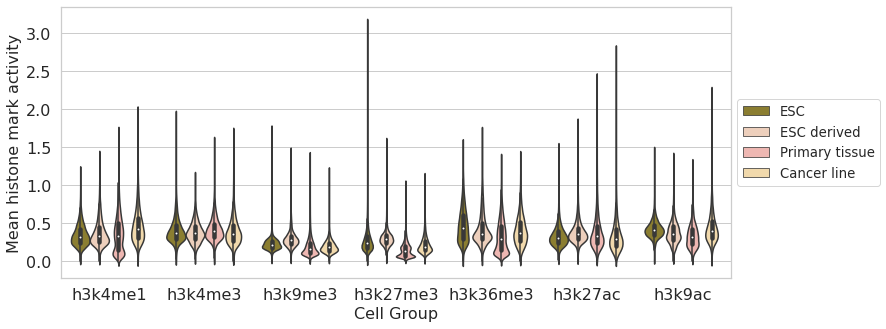

In [137]:
#how variable is the hist mark across active genes 

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

chromo_hist_act_ag = chromo_hist_act.copy()
#filt to just active
chromo_hist_act_ag = chromo_hist_act_ag[chromo_hist_act_ag['exp_label']==1.0]

# Plot
ax = sns.violinplot(x="assay", y="hist_mark_activity", hue="cell_anatomy_grp",
                    palette=pal,data=chromo_hist_act_ag)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set(ylim=(-0.1, 4))

plt.show()


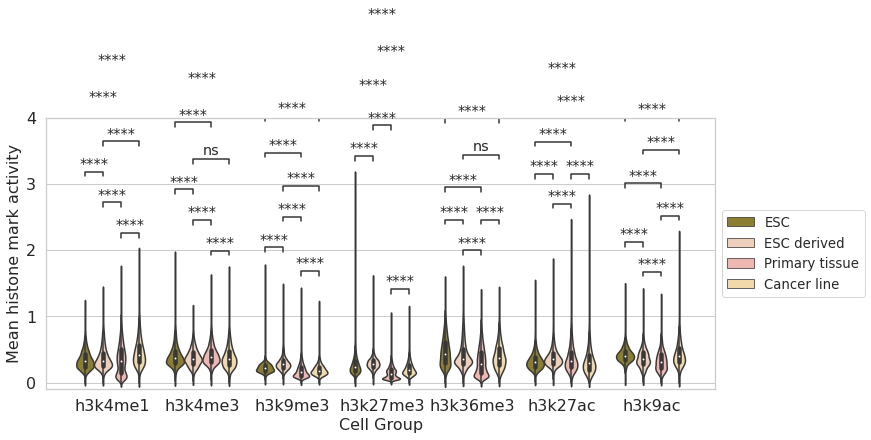

In [138]:
#how variable is the hist mark across active genes 

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

chromo_hist_act_ag = chromo_hist_act.copy()
#filt to just active
chromo_hist_act_ag = chromo_hist_act_ag[chromo_hist_act_ag['exp_label']==1.0]

# Plot
ax = sns.violinplot(x="assay", y="hist_mark_activity", hue="cell_anatomy_grp",
                    palette=pal,data=chromo_hist_act_ag)
add_stat_annotation(ax, data=chromo_hist_act_ag, x="assay", y="hist_mark_activity", hue="cell_anatomy_grp",
                    #order=order,
                    box_pairs=[(("h3k4me1", "Primary tissue"), ("h3k4me1", "Cancer line")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "ESC"), ("h3k4me1", "ESC derived")),
                               
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "Cancer line")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "ESC"), ("h3k4me3", "ESC derived")),
                               
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "Cancer line")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "ESC"), ("h3k9me3", "ESC derived")),
                            
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "Cancer line")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "ESC"), ("h3k27me3", "ESC derived")),
                               
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "Cancer line")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "ESC"), ("h3k36me3", "ESC derived")),
                               
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "Cancer line")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "ESC"), ("h3k27ac", "ESC derived")),
                               
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "Cancer line")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "ESC"), ("h3k9ac", "ESC derived")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='inside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


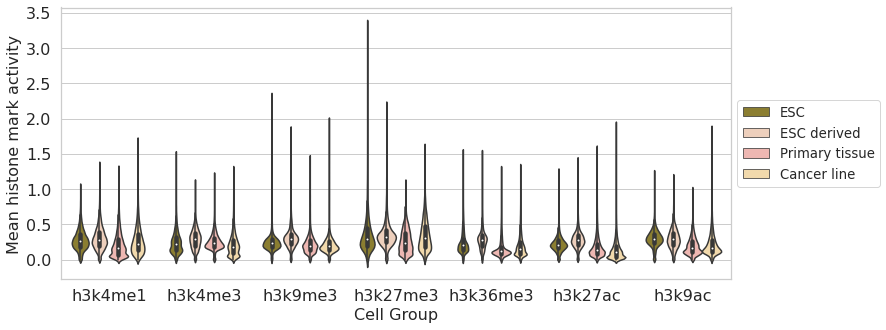

In [139]:
#how variable is the hist mark across inactive genes 

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

chromo_hist_act_inag = chromo_hist_act.copy()
#filt to just inactive
chromo_hist_act_inag = chromo_hist_act_inag[chromo_hist_act_inag['exp_label']==0.0]

# Plot
ax = sns.violinplot(x="assay", y="hist_mark_activity", hue="cell_anatomy_grp",
                    palette=pal,data=chromo_hist_act_inag)

# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
#ax.set(ylim=(-0.1, 4))

plt.show()


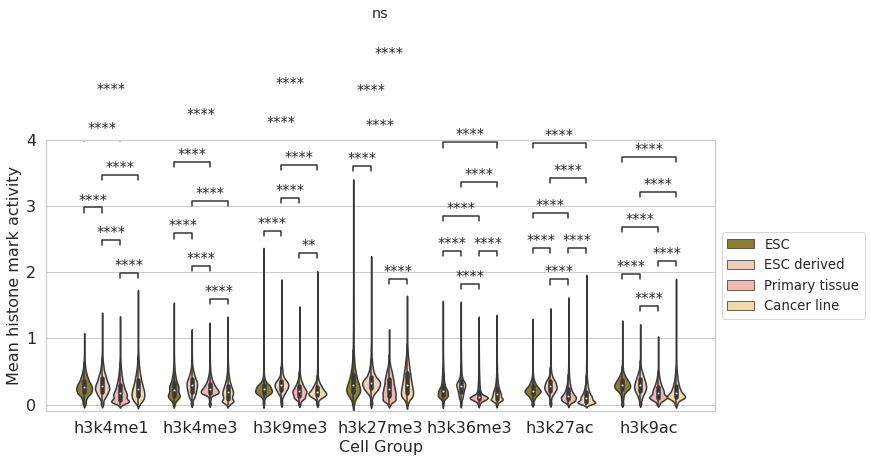

In [140]:
#how variable is the hist mark across inactive genes 

#plot expression across the two cell groups
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(12, 5)})
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

chromo_hist_act_inag = chromo_hist_act.copy()
#filt to just inactive
chromo_hist_act_inag = chromo_hist_act_inag[chromo_hist_act_inag['exp_label']==0.0]

# Plot
ax = sns.violinplot(x="assay", y="hist_mark_activity", hue="cell_anatomy_grp",
                    palette=pal,data=chromo_hist_act_inag)
add_stat_annotation(ax, data=chromo_hist_act_inag, x="assay", y="hist_mark_activity", hue="cell_anatomy_grp",
                    #order=order,
                    box_pairs=[(("h3k4me1", "Primary tissue"), ("h3k4me1", "Cancer line")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Primary tissue"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC")),
                               (("h3k4me1", "Cancer line"), ("h3k4me1", "ESC derived")),
                               (("h3k4me1", "ESC"), ("h3k4me1", "ESC derived")),
                               
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "Cancer line")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Primary tissue"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC")),
                               (("h3k4me3", "Cancer line"), ("h3k4me3", "ESC derived")),
                               (("h3k4me3", "ESC"), ("h3k4me3", "ESC derived")),
                               
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "Cancer line")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Primary tissue"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC")),
                               (("h3k9me3", "Cancer line"), ("h3k9me3", "ESC derived")),
                               (("h3k9me3", "ESC"), ("h3k9me3", "ESC derived")),
                            
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "Cancer line")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Primary tissue"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC")),
                               (("h3k27me3", "Cancer line"), ("h3k27me3", "ESC derived")),
                               (("h3k27me3", "ESC"), ("h3k27me3", "ESC derived")),
                               
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "Cancer line")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Primary tissue"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC")),
                               (("h3k36me3", "Cancer line"), ("h3k36me3", "ESC derived")),
                               (("h3k36me3", "ESC"), ("h3k36me3", "ESC derived")),
                               
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "Cancer line")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Primary tissue"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC")),
                               (("h3k27ac", "Cancer line"), ("h3k27ac", "ESC derived")),
                               (("h3k27ac", "ESC"), ("h3k27ac", "ESC derived")),
                               
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "Cancer line")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Primary tissue"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC")),
                               (("h3k9ac", "Cancer line"), ("h3k9ac", "ESC derived")),
                               (("h3k9ac", "ESC"), ("h3k9ac", "ESC derived")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='inside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
# Put the legend out of the figure
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Cell Group',fontsize=16)
ax.set_ylabel('Mean histone mark activity',fontsize=16)
ax.tick_params(labelsize=16)
ax.set(ylim=(-0.1, 4))

plt.show()


* hard to see if more hist mark activity in better perf cell groups
* let's look at the correlation between perf and hist mark activity
* need to get hist mark act on test folds only for fair comparison

In [156]:
#hard to see if more hist mark activity in better perf cell groups
#let's look at the correlation
#agg so one hist mark activity per cell/mark
chromo_hist_act_tst = pd.read_csv(str(PROJECT_PATH/'model_results/checkpoints/agg_hist_exp_chromo_test_folds.csv'), 
                              sep='\t')
#get metadata
rm_meta = pd.read_csv(str(PROJECT_PATH/'metadata/roadmap_metadata.csv'))
cell_grp = rm_meta[['Epigenome ID (EID)','ANATOMY']]
cell_grp['cell_anatomy_grp'] = np.where(cell_grp['ANATOMY'].isin(['ESC']),
                                         'ESC',np.where(cell_grp['ANATOMY'].isin(['ESC_DERIVED']),'ESC derived',
                                                        np.where(cell_grp['Epigenome ID (EID)'].isin(['E118','E114']),
                                                               'Cancer line','Primary tissue')))

chromo_hist_act_tst = chromo_hist_act_tst.merge(cell_grp,left_on='cell', 
                                                right_on='Epigenome ID (EID)', 
                                                how='left')
chromo_hist_act_agg = chromo_hist_act_tst.copy()
#filter to just active
#chromo_hist_act_agg = chromo_hist_act_agg[chromo_hist_act_agg['exp_label']==0]
chromo_hist_act_agg = chromo_hist_act_agg.groupby(['cell', 'assay',
                                                   'cell_anatomy_grp','fold']).mean().reset_index()
losses_chrom_agg = losses_chrom_.copy()
losses_chrom_agg = losses_chrom_agg.groupby(['cell', 'assay',
                                             'cell_anatomy_grp2','fold']).mean().reset_index()
losses_chrom_agg.rename(columns={'cell_anatomy_grp2':'cell_anatomy_grp'}, inplace=True)
#join so matched
chromo_hist_act_loss_agg = chromo_hist_act_agg.merge(losses_chrom_agg,on=['cell', 
                                                                          'assay',
                                                                          'cell_anatomy_grp',
                                                                          'fold'],
                                                     how='inner')

/tmp/ipykernel_688581/3144902566.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_grp['cell_anatomy_grp'] = np.where(cell_grp['ANATOMY'].isin(['ESC']),


In [161]:
chromo_hist_act_loss_agg

,cell,assay,cell_anatomy_grp,fold,log2RPKM,exp_label,hist_mark_activity,Pearson_R
0,E003,h3k27ac,ESC,1,2.189329,0.435897,0.254141,0.692471
1,E003,h3k27ac,ESC,2,2.028553,0.473684,0.250497,0.782099
2,E003,h3k27ac,ESC,3,2.227474,0.459459,0.262947,0.748708
3,E003,h3k27ac,ESC,4,2.944878,0.700000,0.267925,0.729467
4,E003,h3k27me3,ESC,1,2.189329,0.435897,0.329934,0.488453
...,...,...,...,...,...,...,...,...
303,E118,h3k9ac,Cancer line,4,2.803249,0.575000,0.307877,0.790122
304,E118,h3k9me3,Cancer line,1,1.581700,0.384615,0.189204,0.249422
305,E118,h3k9me3,Cancer line,2,1.755626,0.394737,0.156736,0.358397
306,E118,h3k9me3,Cancer line,3,2.537396,0.567568,0.189037,0.210767


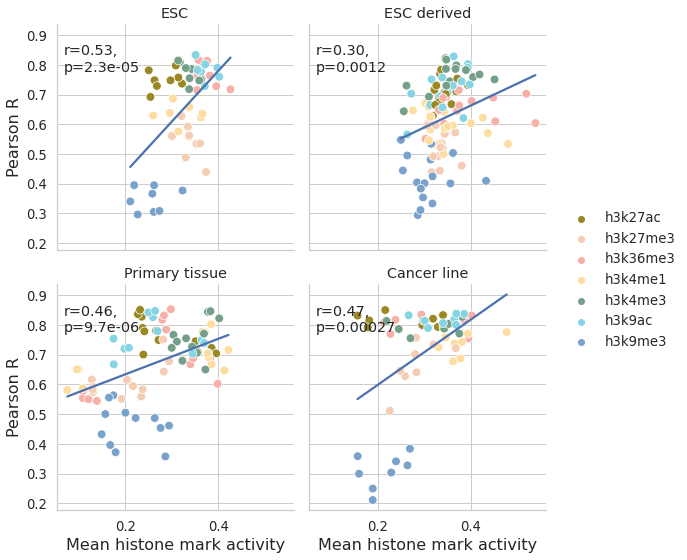

In [159]:
#plot relationship as scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

# Plot
g = sns.FacetGrid(chromo_hist_act_loss_agg, col = 'cell_anatomy_grp',
                  #hue = 'cell_anatomy_grp',
                  palette=pal,
                  col_wrap=2, height=4)
g.map(sns.regplot, 'hist_mark_activity', 'Pearson_R',ci=None,scatter = False,
      scatter_kws={'s':75})
g.map(sns.scatterplot, 'hist_mark_activity', 'Pearson_R',hue='assay',data=chromo_hist_act_loss_agg,
      s=75,palette=pal).add_legend()
def annotate_reg(data, **kws):
    r, p = sp.stats.pearsonr(data['hist_mark_activity'], #data[data['assay']!='h3k9me3']['hist_mark_activity'], 
                             data['Pearson_R'])#data[data['assay']!='h3k9me3']['Pearson_R'])
    ax = plt.gca()
    ax.text(.03, .79, 'r={:.2f},\np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate_reg)

#ax = sns.scatterplot(y="Pearson_R", x="hist_mark_activity", hue="cell_anatomy_grp",
#                    palette=pal[0:4],data=chromo_hist_act_loss_agg)
# Put the legend out of the figure
g.set_axis_labels("Mean histone mark activity", "Pearson R",fontsize=16)
g.set_titles(col_template="{col_name}")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylabel('Pearson R',fontsize=16)
#ax.set_xlabel('Mean histone mark activity',fontsize=16)
#g.tick_params(labelsize=16)
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_corr_hist_act_perf.pdf"),dpi=1000,bbox_inches='tight')
#plt.show()


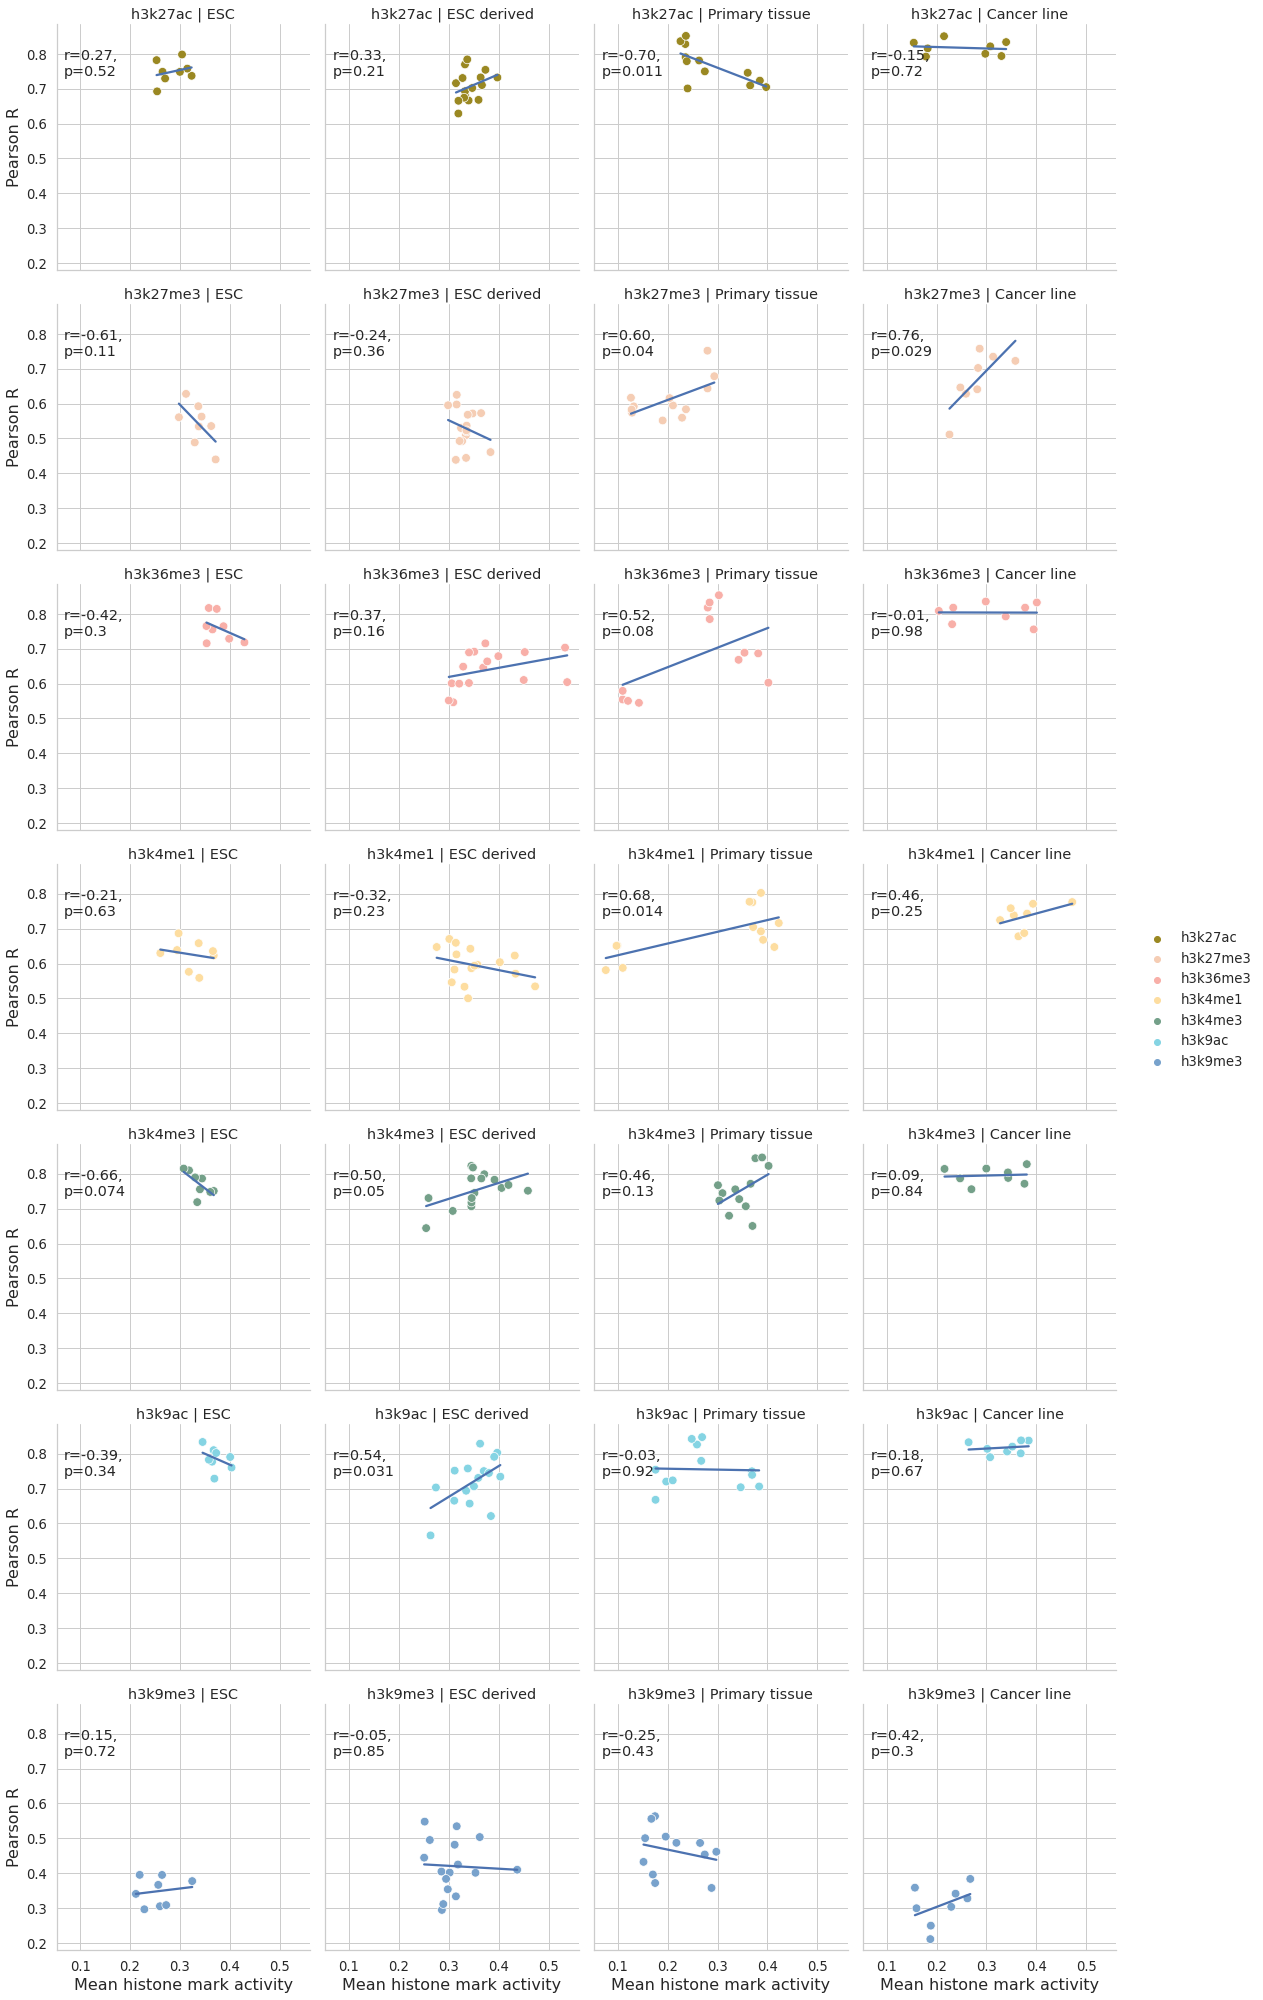

In [152]:
#plot relationship as scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

# Plot
g = sns.FacetGrid(chromo_hist_act_loss_agg, col = 'cell_anatomy_grp',row='assay',
                  #hue = 'cell_anatomy_grp',
                  palette=pal, height=4)
g.map(sns.regplot, 'hist_mark_activity', 'Pearson_R',ci=None,scatter = False,
      scatter_kws={'s':75})
g.map(sns.scatterplot, 'hist_mark_activity', 'Pearson_R',hue='assay',data=chromo_hist_act_loss_agg,
      s=75,palette=pal).add_legend()
def annotate_reg(data, **kws):
    r, p = sp.stats.pearsonr(data['hist_mark_activity'], #data[data['assay']!='h3k9me3']['hist_mark_activity'], 
                             data['Pearson_R'])#data[data['assay']!='h3k9me3']['Pearson_R'])
    ax = plt.gca()
    ax.text(.03, .79, 'r={:.2f},\np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate_reg)

#ax = sns.scatterplot(y="Pearson_R", x="hist_mark_activity", hue="cell_anatomy_grp",
#                    palette=pal[0:4],data=chromo_hist_act_loss_agg)
# Put the legend out of the figure
g.set_axis_labels("Mean histone mark activity", "Pearson R",fontsize=16)
g.set_titles(row_template="{row_name}",col_template="{col_name}")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylabel('Pearson R',fontsize=16)
#ax.set_xlabel('Mean histone mark activity',fontsize=16)
#g.tick_params(labelsize=16)

#plt.show()


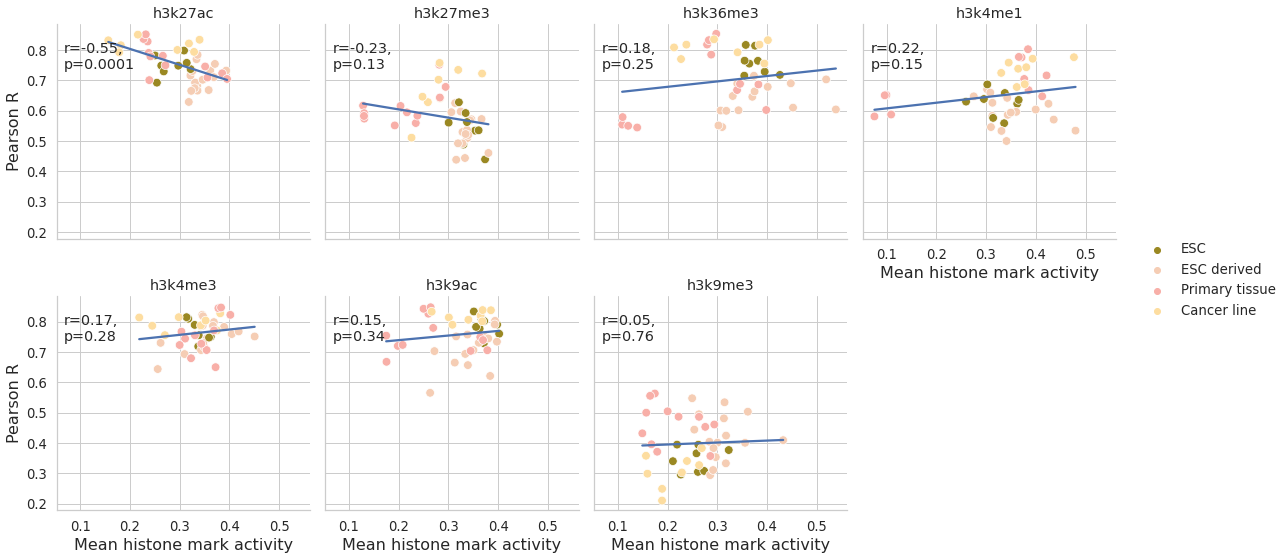

In [22]:
#plot relationship as scatter plot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']

# Plot
g = sns.FacetGrid(chromo_hist_act_loss_agg, col ='assay',
                  #hue = 'cell_anatomy_grp',
                  col_wrap=4,
                  height=4)
g.map(sns.regplot, 'hist_mark_activity', 'Pearson_R',ci=None,scatter = False,
      scatter_kws={'s':75})
g.map(sns.scatterplot, 'hist_mark_activity', 'Pearson_R',hue='cell_anatomy_grp',data=chromo_hist_act_loss_agg,
      s=75,palette=pal[0:4]).add_legend()
def annotate_reg(data, **kws):
    r, p = sp.stats.pearsonr(data['hist_mark_activity'], #data[data['assay']!='h3k9me3']['hist_mark_activity'], 
                             data['Pearson_R'])#data[data['assay']!='h3k9me3']['Pearson_R'])
    ax = plt.gca()
    ax.text(.03, .79, 'r={:.2f},\np={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate_reg)

#ax = sns.scatterplot(y="Pearson_R", x="hist_mark_activity", hue="cell_anatomy_grp",
#                    palette=pal[0:4],data=chromo_hist_act_loss_agg)
# Put the legend out of the figure
g.set_axis_labels("Mean histone mark activity", "Pearson R",fontsize=16)
g.set_titles(col_template="{col_name}")
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylabel('Pearson R',fontsize=16)
#ax.set_xlabel('Mean histone mark activity',fontsize=16)
#g.tick_params(labelsize=16)

#plt.show()


## Chromoformer 2 marks result

In [126]:
#load chromoformer res
import pandas as pd
import pathlib
from epi_to_express.constants import(
    ASSAYS,
    SAMPLES,
    SAMPLE_IDS)

PRED_PATH = pathlib.Path("./model_results/predictions")

losses_chrom_2m = pd.read_csv(f"{PRED_PATH}/chromoformer_combins_blind_test.csv", sep='\t')
#also loadf perf using all hist marks
losses_chrom_all = pd.read_csv(f"{PRED_PATH}/chromoformer_all_hist_perf.csv")

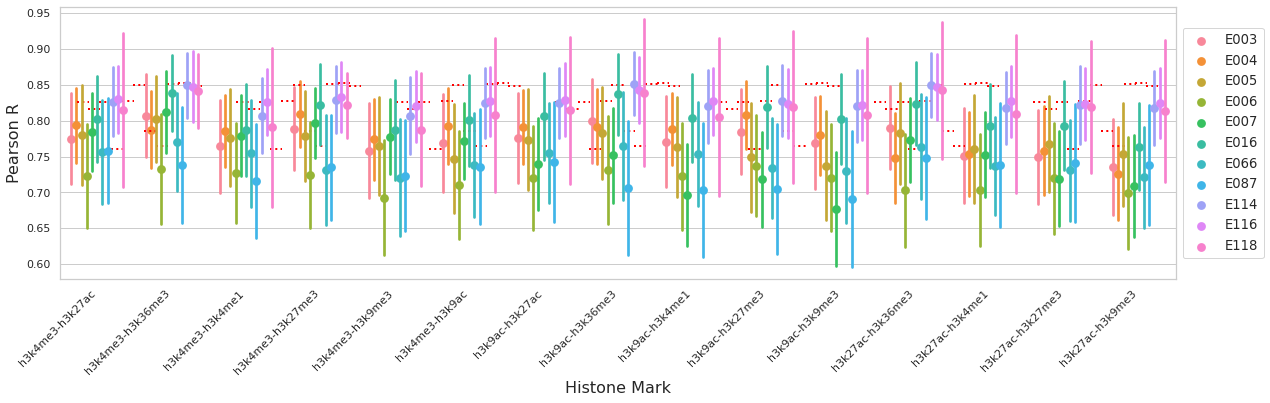

In [127]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom_2m, ci="sd",join=False,
            dodge=0.7
                      )
#add perf of chromoformer for each cell type
cell_mean_perf = losses_chrom_all.groupby(['cell'])['Pearson_R'].mean().values
for ind,asy_i in enumerate(ASSAYS):
    for c_ind,cell_i in enumerate(SAMPLE_IDS):
        perf_plt.axhline(y=cell_mean_perf[c_ind], 
                         lw=2, c='red', ls=':', 
                         xmin=(ind/len(ASSAYS))+.015+((c_ind)/len(SAMPLE_IDS))/9, 
                         xmax=(ind/len(ASSAYS))+.026+((c_ind)/len(SAMPLE_IDS))/9)
    
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.tick_params(axis='x', rotation=45)
perf_plt.set_xticklabels(perf_plt.get_xticklabels(), rotation=45, horizontalalignment='right')

perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)

[(0.6, 1.0)]

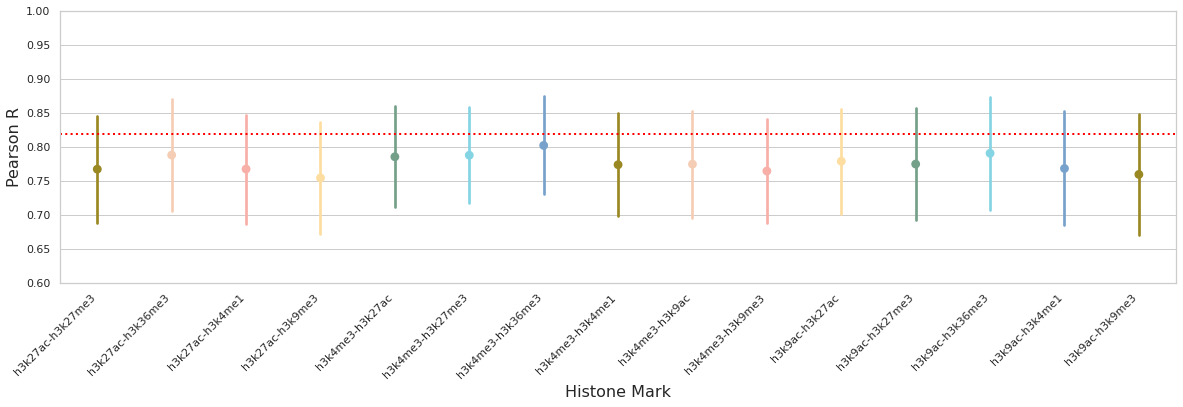

In [131]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#same wesanderson palette as used in R plots
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089","#85D4E3",
       #added extra to make 7
       '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
losses_chrom_2m = losses_chrom_2m.sort_values('assay')
perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom_2m, ci="sd",join=False,
            dodge=0.3, palette=pal)
#add in mean perf of chromoformer using all hist marks
mean_perf = losses_chrom_all['Pearson_R'].mean()
perf_plt.axhline(y=mean_perf, 
                 lw=2, c='red', ls=':', 
                 xmin=0,xmax=1)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.tick_params(axis='x', rotation=45)
perf_plt.set_xticklabels(perf_plt.get_xticklabels(), rotation=45, horizontalalignment='right')
perf_plt.legend([],[], frameon=False)
perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)
perf_plt.set(ylim=(0.6, 1))

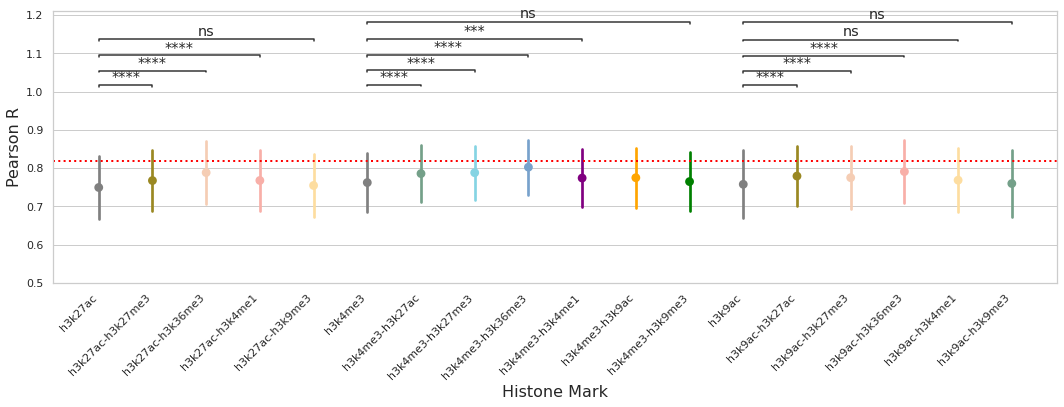

In [163]:
#add in two active prom marks
losses_chrom_ws = pd.concat([losses_chrom_2m,losses_chrom[losses_chrom['assay'].isin(['h3k27ac','h3k4me3','h3k9ac'])]])

#plot
import seaborn as sns
from statannot import add_stat_annotation
sns.set(rc={'figure.figsize':(18, 5)})
#same wesanderson palette as used in R plots
pal = ['grey',
       "#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0",
       'grey',
       "#74A089","#85D4E3",       
       '#78A2CC','purple','orange','green',
       'grey',
       "#9A8822","#F5CDB4","#F8AFA8",
       "#FDDDA0","#74A089"]
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

losses_chrom_ws = losses_chrom_ws.sort_values('assay')

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom_ws, ci="sd",join=False,
            dodge=0.3, palette=pal)
add_stat_annotation(perf_plt, data=losses_chrom_ws, x="assay", y="Pearson_R",
                    box_pairs=[(("h3k27ac-h3k36me3"), ("h3k27ac")),
                               (("h3k27ac-h3k4me1"), ("h3k27ac")),
                               (("h3k27ac-h3k27me3"), ("h3k27ac")),
                               (("h3k27ac-h3k9me3"), ("h3k27ac")),
                        
                               (("h3k4me3-h3k27ac"), ("h3k4me3")),
                               (("h3k4me3-h3k36me3"), ("h3k4me3")),
                               (("h3k4me3-h3k4me1"), ("h3k4me3")),
                               (("h3k4me3-h3k27me3"), ("h3k4me3")),
                               (("h3k4me3-h3k9me3"), ("h3k4me3")),
                               
                               (("h3k9ac-h3k27ac"), ("h3k9ac")),
                               (("h3k9ac-h3k36me3"), ("h3k9ac")),
                               (("h3k9ac-h3k4me1"), ("h3k9ac")),
                               (("h3k9ac-h3k27me3"), ("h3k9ac")),
                               (("h3k9ac-h3k9me3"), ("h3k9ac")),
                              ],
                    test='Mann-Whitney', text_format='star',loc='inside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
#add in mean perf of chromoformer using all hist marks
mean_perf = losses_chrom_all['Pearson_R'].mean()
perf_plt.axhline(y=mean_perf, 
                 lw=2, c='red', ls=':', 
                 xmin=0,xmax=1)
# Put the legend out of the figure

#perf_plt.tick_params(axis='x', rotation=45)
perf_plt.set_xticklabels(perf_plt.get_xticklabels(), rotation=45, horizontalalignment='right')
perf_plt.legend([],[], frameon=False)
perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)
perf_plt.set(ylim=(0.5, 1.21))
plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_model_2hist.pdf"),dpi=1000,bbox_inches='tight')


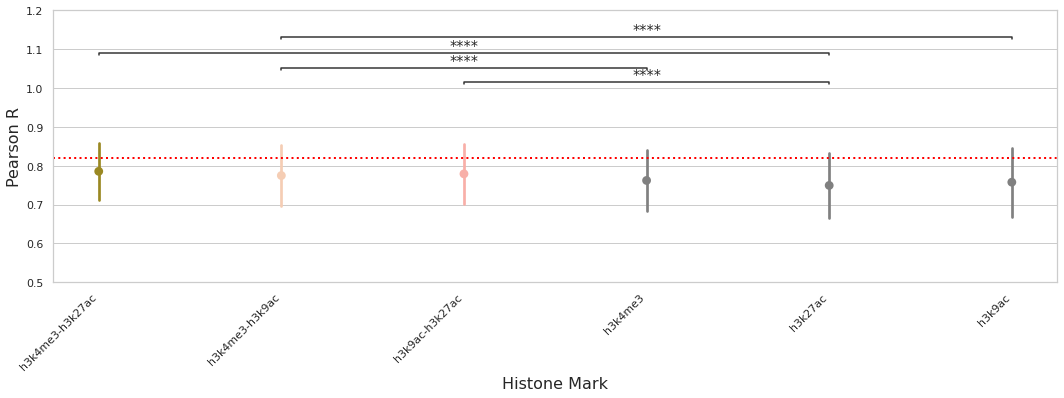

In [164]:
#add in two active prom marks
losses_chrom_ws = pd.concat([losses_chrom_2m,losses_chrom[losses_chrom['assay'].isin(['h3k27ac','h3k4me3','h3k9ac'])]])

#plot
import seaborn as sns
from statannot import add_stat_annotation
sns.set(rc={'figure.figsize':(18, 5)})
#same wesanderson palette as used in R plots
pal = ["#9A8822","#F5CDB4","#F8AFA8",
       'grey','grey','grey']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

losses_chrom_ws2 = losses_chrom_ws[losses_chrom_ws['assay'].isin(["h3k9ac-h3k27ac","h3k4me3-h3k27ac",
                                                                  "h3k27ac","h3k4me3-h3k9ac",
                                                                  "h3k4me3","h3k9ac"])]
#custom order
custom_ord = {'h3k4me3': 5, 'h3k9ac': 4, 'h3k27ac': 3,"h3k4me3-h3k9ac":2,
              "h3k4me3-h3k27ac":1,"h3k9ac-h3k27ac":0} 
losses_chrom_ws2.sort_values(by=['assay'], key=lambda x: x.map(custom_ord))

perf_plt = sns.pointplot(       
            y = "Pearson_R",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses_chrom_ws2,
            ci="sd",join=False,
            dodge=0.3, palette=pal)
add_stat_annotation(perf_plt, data=losses_chrom_ws2, 
                    x="assay", y="Pearson_R",
                    box_pairs=[(("h3k9ac-h3k27ac"), ("h3k27ac")),
                               (("h3k4me3-h3k27ac"), ("h3k27ac")),
                               
                               (("h3k4me3-h3k9ac"), ("h3k4me3")),
                               
                               (("h3k4me3-h3k9ac"), ("h3k9ac"))
                              ],
                    test='Mann-Whitney', text_format='star',loc='inside',verbose=0,
                    comparisons_correction='bonferroni')#doesn't accept BH
#add in mean perf of chromoformer using all hist marks
mean_perf = losses_chrom_all['Pearson_R'].mean()
perf_plt.axhline(y=mean_perf, 
                 lw=2, c='red', ls=':', 
                 xmin=0,xmax=1)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.tick_params(axis='x', rotation=45)
perf_plt.set_xticklabels(perf_plt.get_xticklabels(), rotation=45, horizontalalignment='right')
perf_plt.legend([],[], frameon=False)
perf_plt.set_xlabel('Histone Mark',fontsize=16)
perf_plt.set_ylabel('Pearson R',fontsize=16)
perf_plt.tick_params(labelsize=11)
perf_plt.set(ylim=(0.5, 1.2))

plt.savefig(str(PROJECT_PATH/"model_results"/"plots"/"distal_model_top3_combn.pdf"),dpi=1000,bbox_inches='tight')

In [37]:
diff1 = losses_chrom[losses_chrom['assay'].isin(['h3k4me3','h3k9ac','h3k27ac'])].groupby('assay').mean()
diff1['all_hist_Pearson_R'] = losses_chrom_all['Pearson_R'].mean()
diff1['diff_perc'] = (diff1['all_hist_Pearson_R']-diff1['Pearson_R'])*100
print(diff1['diff_perc'].mean())

diff2 = losses_chrom_2m.groupby('assay').mean()
diff2['all_hist_Pearson_R'] = losses_chrom_all['Pearson_R'].mean()
diff2['diff_perc'] = (diff2['all_hist_Pearson_R']-diff2['Pearson_R'])*100
print(diff2['diff_perc'].mean())
print((diff1['diff_perc'].mean()-diff2['diff_perc'].mean())/diff1['diff_perc'].mean())

6.24292585767882
4.277983167340053
0.3147470809575419


TODO:
* split perf by the ESC/prim tissue four groups because ["H3K9me3 and H3K36me3 dual domains form on thousands of regions in ES cells"](https://www.sciencedirect.com/science/article/pii/S1097276521011424)
    * for both 2 mark and 1 mark

Notes:
* h3k4me3 - indicative of a promoter region [ref](https://science.sciencemag.org/content/366/6469/1134.fullref-11), better than h3k9ac - associated with active promoters [ref](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-424) and h3k27ac still. h3k27ac and h3k9ac very similar.
* Both promoter marks and h3k27ac showed increased performance when a second mark is added with only the exception of h3k9me3 (and h3k4me1 for h3k9ac). h3k9me3 had worst perf on single mark chromoformer run.
* Clear that using two marks brings the predictions closer to the performance of all hist marks but using all still adds information. The difference between the two active promoter marks and h3k27ac (with and without a second mark) and using all marks dropped from 0.062 correlation to 0.043 - a drop of 31%.
* h3k36me3 - heterochromatin [ref](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3166828/) is the top performing mark in combination with the active promoter marks or h3k27ac. What is this telling us that the active enhancer and repressive marks aren't?
    * h3k36me3 actually performed worst in prom model but now is 4th best by itself and best additional mark. Have something to add in enhancer regions.
    * h3k36me3 associated with [intronic enhancers](https://academic.oup.com/nar/article/45/21/12195/4157405)
* Adding any combination of the top 3 marks together outperform any by themselves (significantly).    